<a href="https://colab.research.google.com/github/yasinbastug/CommentToxicityBot/blob/main/comment_toxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow pandas matplotlib sklearn
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df=pd.read_csv('train.csv')

In [ ]:
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
from tensorflow.keras.layers import TextVectorization
X = df['comment_text']
y = df[df.columns[2:]].values
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:

history = model.fit(train, epochs=10, validation_data=val)
from matplotlib import pyplot as plt

Epoch 1/10
6981/6981 [==============================] - 786s 111ms/step - loss: 0.0627 - val_loss: 0.0453
Epoch 2/10
6981/6981 [==============================] - 634s 91ms/step - loss: 0.0452 - val_loss: 0.0459
Epoch 3/10
6981/6981 [==============================] - 626s 90ms/step - loss: 0.0406 - val_loss: 0.0355
Epoch 4/10
6981/6981 [==============================] - 638s 91ms/step - loss: 0.0357 - val_loss: 0.0316
Epoch 5/10
6981/6981 [==============================] - 630s 90ms/step - loss: 0.0320 - val_loss: 0.0275
Epoch 6/10
6981/6981 [==============================] - 616s 88ms/step - loss: 0.0290 - val_loss: 0.0241
Epoch 7/10
6981/6981 [==============================] - 619s 89ms/step - loss: 0.0260 - val_loss: 0.0217
Epoch 8/10
6981/6981 [==============================] - 638s 91ms/step - loss: 0.0233 - val_loss: 0.0204
Epoch 9/10
6981/6981 [==============================] - 625s 89ms/step - loss: 0.0207 - val_loss: 0.0171
Epoch 10/10
6981/6981 [==============================]

In [ ]:
history.history

{'loss': [0.0627230629324913,
  0.04519899934530258,
  0.040621571242809296,
  0.035691048949956894,
  0.031971510499715805,
  0.028951112180948257,
  0.025978773832321167,
  0.02332158386707306,
  0.02073448710143566,
  0.01843990944325924],
 'val_loss': [0.04526063799858093,
  0.04594472423195839,
  0.03554060682654381,
  0.031627263873815536,
  0.027493959292769432,
  0.02409052662551403,
  0.021670881658792496,
  0.02036825194954872,
  0.01705867424607277,
  0.015106581151485443]}

<Figure size 800x500 with 0 Axes>

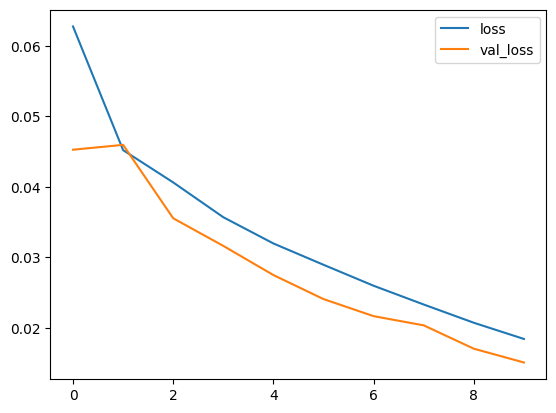

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Predictions

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you if you continue.')

In [ ]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 1s 716ms/step


In [ ]:
(res > 0.5).astype(int)

We can see that the model couldn't classified this comment as a threat. Maybe we should train more with threat comments

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

In [ ]:
res.shape

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


In [ ]:
!pip install gradio jinja2
import tensorflow as tf
import gradio as gr

In [ ]:

!pip install huggingface_hub


In [ ]:
model.save('toxicity.h5')

In [ ]:
%%capture
! pip install git+https://github.com/huggingface/huggingface_hub.git@main
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [ ]:
! huggingface-cli login

In [ ]:
from huggingface_hub import push_to_hub_keras
push_to_hub_keras(model, 'comment_toxicity_model')

In [ ]:
from huggingface_hub import from_pretrained_keras

# Replace nateraw with your username that you logged in with!
m = from_pretrained_keras('yasinbastug/comment_toxicity_model')

In [ ]:
m.summary()

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')
input_str = vectorizer('hey i freaken hate you!')
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 875ms/step


In [ ]:
res

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [ ]:
!git clone https://huggingface.co/spaces/yasinbastug/comment_toxicity

In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

In [ ]:
!gradio deploy

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install gradio jinja2

# YOU CAN TEST THE DEPLOYED MODEL HERE. LET'S GO!!!

##  Requirements
###### You should also upload the training data, you can access it from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [ ]:
!pip install huggingface_hub
!pip install gradio jinja2
from huggingface_hub import from_pretrained_keras
import tensorflow as tf
import gradio as gr
import pandas as pd

## Just one click and there you have it

In [ ]:
from tensorflow.keras.layers import TextVectorization
df = pd.read_csv('train.csv')
X = df['comment_text']
y = df[df.columns[2:]].values
MAX_FEATURES = 200000
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X.values)
m = from_pretrained_keras('yasinbastug/comment_toxicity_model')
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = m.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

interface.launch()

Or you can just use the one I deployed: https://huggingface.co/spaces/yasinbastug/comment_toxicity